# Sequence-to-sequence models

In this lab, we will look at sequence-to-sequence models. When discussing recurrent neural networks, we already considered models that take sequences as input, and return sequences as output. However, the models we see today require looking at the *full* input sequence to build the output sequence.

## Preparation

We start by importing the libraries that we will use throughout.

In [1]:
# Numpy library provides useful numeric computation utilities
import numpy as np

# We import Pyplot for its plotting utilities
import matplotlib.pyplot as plt

# We also import the random library for its randomization utilities
import random

# We import torch and torch.nn for the neural network utilities we will use
import torch
import torch.nn as nn

# We import the Pytorch implementations of several functions
import torch.nn.functional as F

# We also import Pytorch data-handling utilities
import torch.utils.data as datautils

#random.seed(5)
#np.random.seed(5)
#torch.random.manual_seed(5)

In [2]:
t = torch.rand(3, 4)
# Let's now move our tensor to a GPU, if one is available
if torch.cuda.is_available():
    t = t.to('cuda')
    print('Device used to store tensor:', t.device)
    print('Device name:', torch.cuda.get_device_name(0))
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,3), 'MB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**2,3), 'MB')
    device = torch.device('cuda:0')
else:
    print('No GPU available.')
    device = torch.device('cpu')
    
print(device)

Device used to store tensor: cuda:0
Device name: Quadro RTX 3000
Allocated: 0.0 MB
Cached:    2.0 MB
cuda:0


To make our life easier further ahead, we create auxiliary functions to train and evaluate networks. The first function, `evaluate`, computes the accuracy of the network in a given dataset. It receives, as arguments,

* The neural network
* The dataset object.

It returns the accuracy of the network. The accuracy of the network counts how many characters the network is able to generate correctly, from the input sequence and given the correct previous sub-sequence.

In [3]:
def evaluate(net, dataset):
    
    # We first set the network to evaluation mode
    net.eval()

    acc = 0
    dataset_size = 0
    
    # We run through the dataset, not computing gradients
    with torch.no_grad():
        
        # The input-output pairs consist of sequences, which we refer as the
        # source and target sequences
        for source_seq, target_seq in dataset:
            
            # We want to evaluate the model's ability to generate the *next* 
            # character given the previous one. To that purpose, we feed the
            # decoder with the *correct* previous characters, obtained from 
            # the target sequence. 

            # The input for the decoder is, therefore, the target sequence minus
            # the last character.
            decoder_in = target_seq[:, :-1]
            
            # We use our network to predict the scores for the output sequence, 
            # given the input sequence and the decoder input
            output_scores, _ = net(source_seq, decoder_in)
            
            # From the scores, we compute the most likely next character
            _,  output_seq = torch.max(output_scores, dim=1)

            # The desired output consists of the target sequence (except 
            # the first character).
            desired_seq = target_seq[:, 1:].contiguous().view(-1)

            # Note: The "contiguous" method pushes the tensor to a contiguous 
            # region in memory, which leads to faster computations. The "view" 
            # method provides a specific view of the tensor. In the present 
            # case, it is a one-dimensional tensor with dimension inferred from
            # the object size.
            
            # Compute accuracy
            acc += (output_seq == desired_seq).sum().item()
            
            dataset_size += desired_seq.size(0)

        # Average
        acc = acc / dataset_size

    # We reset the network back to training mode
    net.train()
        
    return acc

We also define a function to be used when training the neural network. We call this function `train_network`. The function shall receive, as arguments:

* The neural network
* The loss function
* The optimizer
* The training set
* The validation set

We'll also include an optional parameter to specify the number of epochs (we'll use 30 as the default value).

In [4]:
def train_network(net, loss, optimizer, train_dataset, valid_dataset, epochs=30):

    # We define an auxiliary function that takes care of the training for a 
    # epoch. This function is "invisible" outside the "train_network" function.
    
    def train_epoch(net, dataset):
        
        # We use an auxiliary variable to keep track of the loss within an 
        # epoch
        running_loss = 0.
        
        dataset.shuffle()
        
        for source_seq, target_seq in dataset:
            
            # We first zero-out the gradients
            optimizer.zero_grad()
            
            # We build the decoder input from the target sequence
            decoder_in = target_seq[:, :-1]
            
            # We compute the output
            output_scores, _ = net(source_seq, decoder_in)
            
            # Desired ouput
            desired_seq = target_seq[:, 1:].contiguous().view(-1)

            # Compute the loss
            l = loss(output_scores, desired_seq)
            
            # Compute gradient
            l.backward()

            # Perform optimization step
            optimizer.step()

            # Update the total running loss
            running_loss += l.item()
        
        return running_loss

    # We start by initializing two lists, to track the performance during 
    # training
    train_losses = []
    valid_accuracies = []
    
    for ep in range(epochs):
        print(f'\n- Training epoch: {ep} -')
        
        train_losses += [train_epoch(net, train_dataset)]
        valid_accuracies += [evaluate(net, valid_dataset)]

        print(f'Training loss: {train_losses[-1]:.4f}')
        print(f'Validation accuracy: {valid_accuracies[-1]:.1%}')

    return net, train_losses, valid_accuracies

## Preparing the dataset

The data we will be using today will be generated synthetically. We will build a set of strings comprising the letters `"a"`, `"b"`, `"c"`, and `"d"`, plus the characters `"<bos>"` and `"<eos>"`, standing for "beginning of sentence" and "end of sentence", respectively. 

Our network should learn to _invert_ the input string. To that purpose, we define some auxiliary functions that generate random sequences using the aforementioned 4 characters, and invert them to create the dataset.

In [5]:
LETTERS = ['a', 'b', 'c', 'd']

BOS = "<bos>"
EOS = "<eos>"

# Index to string mapping: given an index, it returns the corresponding string
I2S  = [BOS, EOS] + LETTERS

# String to index mapping: given a string, it returns the corresponding index 
S2I = {BOS: 0, EOS: 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5}

def gen_string(min_len, max_len):
    ''' 
        Function to generate a random string with length between 
        min_len and max_len.
    '''
    
    # Sample sequence length
    seq_len = random.randint(min_len, max_len)
    
    # Sample sequence
    seq = [random.choice(LETTERS) for _ in range(seq_len)]
    
    # Return generated string (no <BOS> or <EOS>)
    return "".join(seq)

def gen_string_batch(min_len, max_len, size):
    '''
        Function to generate a batch of strings with length between´
        min_len and max_len with given size.
    '''

    return [gen_string(min_len, max_len) for _ in range(size)]

def string2tensor(string):
    '''
        Function to convert a string to a tensor of indices. <EOS> and
        <BOS> are added now.
    '''

    seq = [BOS] + list(string) + [EOS]
    index_seq = [S2I[x] for x in seq]
    
    # We use unsqueeze to add an initial dimension to the beginning, 
    # to facilitate concatenation later on.
    return torch.tensor(index_seq, dtype=torch.long).unsqueeze(0)

We now build a dataset class to hold our data.

In [6]:
class StringDataset(datautils.Dataset):
    def __init__(self, min_len, max_len, size):
        strings = gen_string_batch(min_len, max_len, size)

        self.samples = []
        
        for seq in strings:
            straight_seq = string2tensor(seq)
            reversed_seq = string2tensor(reversed(seq))

            self.samples += [(straight_seq, reversed_seq)]

    def shuffle(self):
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

We can now create our datasets.

In [7]:
# Number of samples in the training set:
train_size = 200

# Number of samples in validation set
valid_size = 100

train_set = StringDataset(3, 15, train_size)
valid_set = StringDataset(3, 15, valid_size)

## Creating a sequence-to-sequence model

Let us now create our sequence-to-sequence model. Our model will consist of an encoder and a decoder, both of which will consist of recurrent neural networks. The encoder has a structure similar to that of pooled classification models, where a sequence is processed to a single output. The decoder has a structure similar to that of sequence generation models, which generates sequences auto-regressively.

We start by defining the encoder as an RNN network. We allow our model to be either single- or bi-directional. Unlike the previous lab, we do not manually run each element of the sequence through the recurrent layer, but instead allow the layer to process the whole sequence automatically.

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, bidirectional=False):
        super().__init__()

        # We create an embedding layer to convert the input to a feature vector
        self.i2f_layer = nn.Embedding(input_size, embedding_size)

        # If we use a bi-directional network, we split the dimension of the 
        # hidden vector by the two networks, the forward network and the
        # backward network
        if bidirectional:
            hidden_size //= 2
        
        # We now create our LSTM layer. The argument "batch_first" indicates 
        # that the first coordinate of the input tensor corresponds to the size
        # of the batch
        self.f2h_layer = nn.LSTM(embedding_size, 
                                 hidden_size, 
                                 bidirectional=bidirectional, 
                                 batch_first=True)

    def _reshape_hidden(self, hidden):
        ''' 
            This function is used to reshape the hidden vector when the network
            is bidirectional. It uses the auxiliary function "_merge_tensor".
        '''
        
        def _merge_tensor(hidden):
            # If the network is bidirectional, then hidden is a tensor with 
            # dimension (2, hidden_size), otherwise (1, hidden_size).
            forward_hidden  = hidden[::2]
            backward_hidden = hidden[1::2]
            
            # Merges the two hidden states (forward and backward) into a single
            # hidden tensor
            return torch.cat([forward_hidden, backward_hidden], 2)

        # Make sure that reshape only happens if the network is bidirectional
        assert self.f2h_layer.bidirectional

        # If the layer's hidden state is a tuple (in LSTM that is the case)
        # then treat each element of the tuple separately
        if isinstance(hidden, tuple):
            return tuple(_merge_tensor(h) for h in hidden)
        else:
            return _merge_tensor(hidden)

    def forward(self, input, hidden=None):
        
        # Process the whole input sequence
        f = self.i2f_layer(input)

        # "hidden" is a tuple containing both the hidden state and the cell 
        # tensor of the LSTM layer
        output, hidden = self.f2h_layer(f, hidden)

        # In bi-directional networks, hidden will include both the forward and
        # the backward hidden vectors, which need to be reshaped accordingly
        if self.f2h_layer.bidirectional:
            hidden = self._reshape_hidden(hidden)
        
        return output, hidden

We also need to define the decoder. The decoder is also an LSTM network, and (to save some trouble further ahead) we will implement it to work both with and without attention.

In [9]:
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, attention=None):
        super().__init__()
        
        self.hidden_size = hidden_size
        
        # Create an embedding layer, to process the input sequence
        # (e.g., used in auto-regression)
        self.i2f_layer = nn.Embedding(input_size, embedding_size)

        # LSTM layer (unidirectional - inputs are processed sequentially)
        self.f2h_layer = nn.LSTM(embedding_size, hidden_size, batch_first=True)

        # Output layer that returns scores over output_size 
        self.h2o_layer = nn.Linear(hidden_size, output_size)
        
        self.attention = attention

    def forward(self, input, encoder_out, hidden):
        ''' 
            The forward pass receives 3 input arguments:
            - "input" corresponds to the input sequence;
            - "hidden" corresponds to the corresponding hidden states;
            - "encoder_out" corresponds to the encoder output for the attention 
              mechanism.
        '''
        
        # Process the whole input sequence
        f = self.i2f_layer(input)
        
        # "hidden" is a tuple containing both the hidden state and the cell 
        # tensor of the LSTM layer
        o, hidden = self.f2h_layer(f, hidden)

        # "context" is the input sequence information coming from the encoder
        # When available, we use it to compute the alignment mask with the
        # current query
        alignment = None
        
        # Use attention layer to compute the weighted output and alignment
        # tensor
        if self.attention is not None:
            o, alignment = self.attention(o, encoder_out)

        # Reshape output to the correct size (N, len(seq), hidden_size)
        o = o.contiguous().view(-1, self.hidden_size)

        # Compute output
        o = self.h2o_layer(o)
        
        return o, hidden, alignment

Finally, we can build our sequence to sequence class by putting the encoder and decoder together, into an encoder-decoder model.

In [10]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        # The sequence to sequence model consists of the encoder and decoder
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source_seq, target_seq):
        
        # In the forward pass, we run the source sequence through the encoder
        # We get the context and last hidden state
        encoder_out, hidden = self.encoder(source_seq)

        # To generate the output sequence, we pass the context to the decoder,
        # initialize its hidden state to that coming from the encoder, and 
        # pass the target sequence to the decoder, to ensure that the 
        # generation comes from the right sequence ("teacher-forcing")
        out, hidden, alignment = self.decoder(target_seq, 
                                              encoder_out=encoder_out, 
                                              hidden=hidden)

        return out, alignment

    def sample(self, source_seq, max_length=None):
        ''' 
            We will use this function to generate output sequences given an 
            source sequence.
        '''
            
        # During sampling, we store no gradient information
        self.eval()

        # Beginning and end of sentence tensors
        bos_tensor = torch.tensor([0], dtype=torch.long).unsqueeze(0)
        eos_tensor = torch.tensor([1], dtype=torch.long).unsqueeze(0)

        source_seq = string2tensor(source_seq)

        with torch.no_grad():
            encoder_out, hidden = self.encoder(source_seq)
          
            # We initialize the output string with the BOS tensor
            output = bos_tensor

            # While not <EOS>
            while True:
                out, _, _ = self.decoder(output,
                                         encoder_out=encoder_out,
                                         hidden=hidden)
                
                # Select next symbol
                _, next_idx = torch.max(out, dim=1)

                output = torch.cat((bos_tensor, next_idx.unsqueeze(0)), dim=1)

                # If the next symbol is <EOS>, we stop
                if next_idx[-1] == 1:
                    break
                
                # If string is too long, add eos and stop
                elif max_length is not None and len(next_idx) > max_length:
                    output = torch.cat((output, eos_tensor), dim=1)
                    break

        self.train()

        output = ''.join([I2S[x] for x in output.squeeze(0)[1:-1]])

        return output

We can now define our sequence-to-sequence model. We use a unidirectional model without attention.

In [11]:
input_size     = len(I2S)
embedding_size = len(I2S)
hidden_size    = 64
output_size    = input_size

enc = Encoder(input_size, embedding_size, hidden_size)
dec = Decoder(input_size, embedding_size, hidden_size, output_size)

# We are not going to train the embedding layers in the encoder or decoder, 
# since in our application, the vocabulary is trivially small
enc.i2f_layer.weight.data = torch.eye(input_size)
enc.i2f_layer.weight.requires_grad = False

dec.i2f_layer.weight.data = enc.i2f_layer.weight.data
dec.i2f_layer.weight.requires_grad = False

# We create our model
seq2seq_net = Seq2Seq(enc, dec)
print(seq2seq_net)

Seq2Seq(
  (encoder): Encoder(
    (i2f_layer): Embedding(6, 6)
    (f2h_layer): LSTM(6, 64, batch_first=True)
  )
  (decoder): Decoder(
    (i2f_layer): Embedding(6, 6)
    (f2h_layer): LSTM(6, 64, batch_first=True)
    (h2o_layer): Linear(in_features=64, out_features=6, bias=True)
  )
)


Let's see how well our network is able to invert sequences...

In [12]:
for i in range(5):
    source = gen_string(3, 15)
    out = seq2seq_net.sample(source, max_length=15)
    print(f'Network converted {source} to {out}')

Network converted aabbbdd to aaaaaaaaaaaaaaaa
Network converted dacc to aaaaaaaaaaaaaaaa
Network converted aad to aaaaaaaaaaaaaaaa
Network converted bccbbdbdc to aaaaaaaaaaaaaaaa
Network converted cdbccacdaad to aaaaaaaaaaaaaaaa


We now proceed with training our network.

In [13]:
# We define the loss
loss = nn.CrossEntropyLoss()

# We setup our optimizer
optimizer = torch.optim.SGD(seq2seq_net.parameters(), lr=0.1)

# ... and we run the training routine
seq2seq_net, train_loss, valid_acc = train_network(seq2seq_net, loss, optimizer, train_set, valid_set, epochs=70)


- Training epoch: 0 -
Training loss: 329.2283
Validation accuracy: 25.7%

- Training epoch: 1 -
Training loss: 319.1867
Validation accuracy: 21.5%

- Training epoch: 2 -
Training loss: 315.7052
Validation accuracy: 25.7%

- Training epoch: 3 -
Training loss: 311.5084
Validation accuracy: 24.4%

- Training epoch: 4 -
Training loss: 308.8984
Validation accuracy: 24.4%

- Training epoch: 5 -
Training loss: 307.7888
Validation accuracy: 24.4%

- Training epoch: 6 -
Training loss: 307.5509
Validation accuracy: 26.0%

- Training epoch: 7 -
Training loss: 306.8296
Validation accuracy: 26.7%

- Training epoch: 8 -
Training loss: 306.2311
Validation accuracy: 26.7%

- Training epoch: 9 -
Training loss: 304.2773
Validation accuracy: 25.7%

- Training epoch: 10 -
Training loss: 293.9386
Validation accuracy: 28.8%

- Training epoch: 11 -
Training loss: 284.2842
Validation accuracy: 25.3%

- Training epoch: 12 -
Training loss: 273.7654
Validation accuracy: 28.7%

- Training epoch: 13 -
Training lo

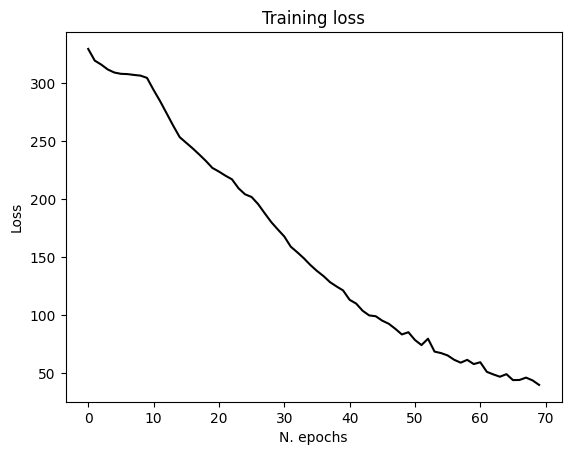

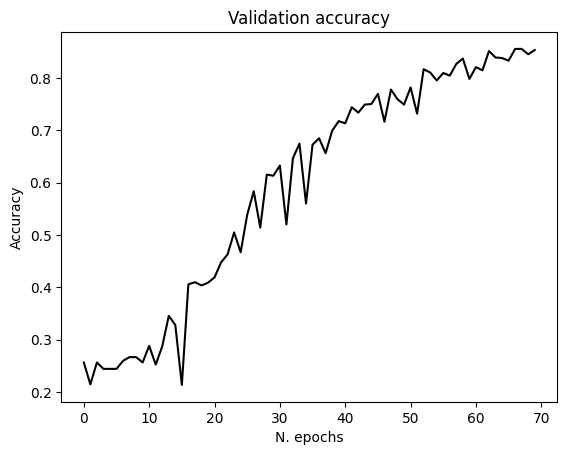

In [14]:
plt.figure()
plt.plot(train_loss, 'k-')
plt.xlabel('N. epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

plt.figure()
plt.plot(valid_acc, 'k-')
plt.xlabel('N. epochs')
plt.ylabel('Accuracy')
plt.title('Validation accuracy')
plt.show()

Let's see how well our model does in inverting sequences.

In [15]:
for i in range(20):
    source = gen_string(3, 15)
    out = seq2seq_net.sample(source)
    print(f'Network converted {source} to {out}')

Network converted bbcacdddacabd to dbacaddacbdcb
Network converted dddab to baddd
Network converted bcadcc to ccdacb
Network converted cdaacbbbba to abbbbcaacd
Network converted dbbbbccbabbcdb to bdbcbabcbbabbc
Network converted ddaaabdbdaaadcc to ccdaaabdabdadca
Network converted daad to daad
Network converted adddbccbcabdc to dcbacbbcdadcc
Network converted cacdcbadadbcc to ccbdadcbacdcd
Network converted ccaaadad to dadaacdc
Network converted cdc to cdc
Network converted bbadcdbca to abccddbcb
Network converted cddcdaadbcc to ccbdaacddcd
Network converted cbdb to bdbc
Network converted cccdddcaa to aacddcdcc
Network converted ddbcdcdaadcdc to cddaacdbadcdb
Network converted daad to daad
Network converted bdbcdbcaaaad to adaacbadbcbd
Network converted acaacaca to acacacaa
Network converted adbbd to dbbda


## Adding attention

Our previous model managed to determine a "relatively correct" output sequence, but it often struggled with longer sequences. This can be explained by noting that the decoder---the part of our model that builds the output sequence---uses *only* the *last* hidden state from the encoder to jump start the output sequence generation. The last hidden state from the encoder has recently seen the final element of the source sequence---which in our case corresponds to the first element it needs to output---but the other elements (that appeared earlier in the input sequence) less recently.

Attention mechanisms are extra layers added to the decoder that allow the generation process to consider hidden state information regarding *all* elements in the input sequence. Such information is provided in the `context` variable, which is the output of the encoder and, in its essence, is just a concatenation of all the hidden states of the encoder.

In this exercise, we consider a simple but effective attention mechanism called *dot-product attention*.

In [16]:
# We define dot-product attention as a subclass of nn.Module
#
# The goal of the attention mechanism is to weight the information from the 
# input sequence as we progress in the generation of the output sequence. 
#
# In the dot-product attention, the weights are computed simply by taking the 
# dot-product between the query (the decoder hidden state) and the keys (the
# encoder states). The resulting values are run through a softmax function,
# yielding the weights to be used to weight the encoder output information.
#
# To compute the final output we use Luong attention, and combining the context 
# information with the query through a standard FC layer.

class DotProdAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()

        self.att_layer = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh()
        )

    def forward(self, query, encoder_out):
        '''
            The forward pass receives 2 input arguments:
            - "query" corresponds to the query vector (e.g., the decoder state)
            - "encoder_out" corresponds to the encoder output.
        '''
        
        # Compute product between query and keys (context) 
        # Notes: 
        #   - bmm is "batch matrix multiplication"
        #   - transpose(a, b) swaps dimensions a and b
        scores = torch.bmm(query, encoder_out.transpose(1, 2))
        
        # Compute attention weights (applies softmax to dim 2)
        weights = torch.softmax(scores, 2)

        # Compute product between attention weights and values (context)
        context = torch.bmm(weights, encoder_out)

        # Concatenate query and context along dim 2
        state = self.att_layer(torch.cat([context, query], 2))
        
        return state, weights

We now create a new sequence-to-sequence model that uses a bi-directional encoder and a decoder with the attention layer just defined.

In [17]:
input_size     = len(I2S)
embedding_size = len(I2S)
hidden_size    = 64
output_size    = input_size

att = DotProdAttention(hidden_size)
enc = Encoder(input_size, embedding_size, hidden_size, bidirectional=True)
dec = Decoder(input_size, embedding_size, hidden_size, output_size, attention=att)

# We are not going to train the embedding layers in the encoder or decoder, 
# since in our application, the vocabulary is trivially small
enc.i2f_layer.weight.data = torch.eye(input_size)
enc.i2f_layer.weight.requires_grad = False

dec.i2f_layer.weight.data = enc.i2f_layer.weight.data
dec.i2f_layer.weight.requires_grad = False

# We create our model
attention_net = Seq2Seq(enc, dec)
print(attention_net)

Seq2Seq(
  (encoder): Encoder(
    (i2f_layer): Embedding(6, 6)
    (f2h_layer): LSTM(6, 32, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (i2f_layer): Embedding(6, 6)
    (f2h_layer): LSTM(6, 64, batch_first=True)
    (h2o_layer): Linear(in_features=64, out_features=6, bias=True)
    (attention): DotProdAttention(
      (att_layer): Sequential(
        (0): Linear(in_features=128, out_features=64, bias=True)
        (1): Tanh()
      )
    )
  )
)


Let's see how well our network is able to invert sequences before training.

In [18]:
for i in range(5):
    source = gen_string(3, 15)
    out = attention_net.sample(source, max_length=15)
    print(f'Network converted {source} to {out}')

Network converted bbcaaaacbacdadd to bbbbbbbbbbbbbbbb
Network converted daaadbbbcabadc to bbbbbbbbbbbbbbbb
Network converted aabdbccbabdddca to bbbbbbbbbbbbbbbb
Network converted cccbdcddbaccad to bbbbbbbbbbbbbbbb
Network converted adaaaa to bbbbbbbbbbbbbbbb


We train our network.

In [19]:
# We setup our optimizer
optimizer = torch.optim.SGD(attention_net.parameters(), lr=0.1)

# ... and we run the training routine
attention_net, train_att_loss, valid_att_acc = train_network(attention_net, loss, optimizer, train_set, valid_set, epochs=30)


- Training epoch: 0 -
Training loss: 327.7853
Validation accuracy: 20.9%

- Training epoch: 1 -
Training loss: 318.5118
Validation accuracy: 23.5%

- Training epoch: 2 -
Training loss: 316.3103
Validation accuracy: 25.9%

- Training epoch: 3 -
Training loss: 312.0602
Validation accuracy: 22.6%

- Training epoch: 4 -
Training loss: 307.0321
Validation accuracy: 28.8%

- Training epoch: 5 -
Training loss: 303.9589
Validation accuracy: 28.4%

- Training epoch: 6 -
Training loss: 301.0102
Validation accuracy: 25.7%

- Training epoch: 7 -
Training loss: 293.3781
Validation accuracy: 30.2%

- Training epoch: 8 -
Training loss: 282.0612
Validation accuracy: 39.1%

- Training epoch: 9 -
Training loss: 267.1511
Validation accuracy: 42.3%

- Training epoch: 10 -
Training loss: 251.6277
Validation accuracy: 46.4%

- Training epoch: 11 -
Training loss: 232.2169
Validation accuracy: 52.0%

- Training epoch: 12 -
Training loss: 218.2614
Validation accuracy: 56.5%

- Training epoch: 13 -
Training lo

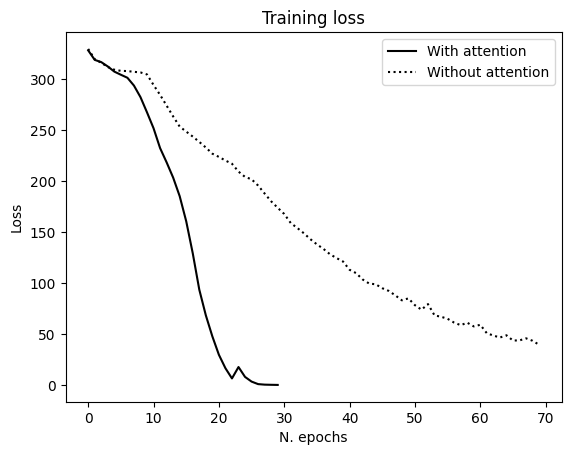

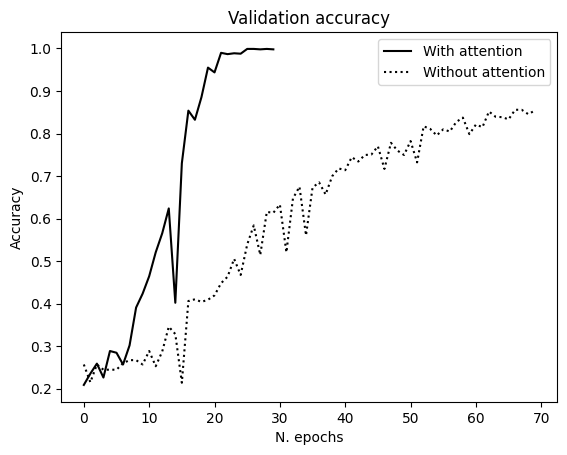

In [20]:
plt.figure()
plt.plot(train_att_loss, 'k-', label='With attention')
plt.plot(train_loss, 'k:', label='Without attention')
plt.xlabel('N. epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(valid_att_acc, 'k-', label='With attention')
plt.plot(valid_acc, 'k:', label='Without attention')
plt.xlabel('N. epochs')
plt.ylabel('Accuracy')
plt.title('Validation accuracy')
plt.legend(loc='best')
plt.show()

Let's now see how well our trained model does in inverting sequences.

In [21]:
for i in range(20):
    source = gen_string(3, 15)
    out = attention_net.sample(source)
    print(f'Network converted {source} to {out}')

Network converted bcdddcaaaaccadc to cdaccaaaacdddcb
Network converted ddaacabadabb to bbadabacaadd
Network converted bddcddbbcbacba to abcabcbbddcddb
Network converted dcdbdb to bdbdcd
Network converted adbddaabacbbd to dbbcabaaddbda
Network converted bbbbbdcdaac to caadcdbbbbb
Network converted aad to daa
Network converted cdddaa to aadddc
Network converted cbcbcadaca to acadacbcbc
Network converted cccaacdcacd to dcacdcaaccc
Network converted daadaddbb to bbddadaad
Network converted dbbbdadddbc to cbdddadbbbd
Network converted abadbcbb to bbcbdaba
Network converted ccbcbbcddbabbbd to dbbbabddcbbcbcc
Network converted cbdab to badbc
Network converted dcda to adcd
Network converted cabbcccacdcbc to cbcdcacccbbac
Network converted aacb to bcaa
Network converted adddbaccccbbba to abbcbcccabddda
Network converted aacacaccd to dccacacaa


We can also visualize the model's attention matrix.

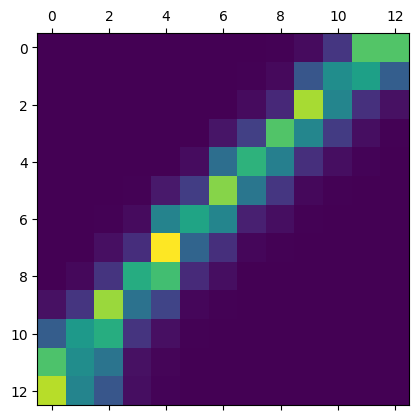

In [22]:
# Let's pick some arbitrary sequence
string = "abacadabacc"
reversed_string = reversed(string)

source = string2tensor(string)
target = string2tensor(reversed_string)

with torch.no_grad():
    _, alignment = attention_net(source, target)

attention_mat = alignment.squeeze(0).numpy()
plt.matshow(attention_mat)
plt.show()

# Activities

## 1. Consider the vectors
```
h1 = torch.tensor([[-2.0, 1.0, 0.5]])
h2 = torch.tensor([[1.0, 1.5, -0.5]])
h3 = torch.tensor([[-1.5, 1.0, -0.5]])
h4 = torch.tensor([[-2.0, -2.5, 1.5]])
```
Suppose also that you have a query vector
```
qt = torch.tensor([[-2.0, 1.0, -1.0]])
```
What is the context `ct` resulting from using dot-product attention?

In [23]:
h1 = torch.tensor([[-2.0, 1.0, 0.5]])
h2 = torch.tensor([[1.0, 1.5, -0.5]])
h3 = torch.tensor([[-1.5, 1.0, -0.5]])
h4 = torch.tensor([[-2.0, -2.5, 1.5]])

k = torch.cat([h1, h2, h3, h4]).T
k

tensor([[-2.0000,  1.0000, -1.5000, -2.0000],
        [ 1.0000,  1.5000,  1.0000, -2.5000],
        [ 0.5000, -0.5000, -0.5000,  1.5000]])

In [24]:
qt = torch.tensor([[-2.0, 1.0, -1.0]])
sim = torch.matmul(qt, k)
sim

tensor([[4.5000, 0.0000, 4.5000, 0.0000]])

In [25]:
m = nn.Softmax(dim=1)
soft = m(sim)
soft

tensor([[0.4945, 0.0055, 0.4945, 0.0055]])

In [26]:
ct = torch.matmul(soft, torch.cat([h1, h2, h3, h4]))
ct

tensor([[-1.7363,  0.9835,  0.0055]])

## 2. Suppose now that we want to compute self-attention for the same tensors `h1`, `h2`, `h3`, `h4`, using the matrices
```
WQ = torch.tensor([[ 1.0, -1.5],
                      [ 0.0,  2.0],
                      [-0.5, -1.0]])
WK = torch.tensor([[-1.5, -1.0],
                      [ 2.5,  0.0],
                      [ 0.5, -1.0]])
WV = torch.tensor([[ 1.0,  2.5],
                      [-0.5, -2.0],
                      [ 0.0, -1.0]])
```

What are `Q`, `K`, `V` in this case? And what is the resulting context?

In [27]:
WQ = torch.tensor([[ 1.0, -1.5], [ 0.0,  2.0], [-0.5, -1.0]])
WK = torch.tensor([[-1.5, -1.0], [ 2.5,  0.0], [ 0.5, -1.0]])
WV = torch.tensor([[ 1.0,  2.5], [-0.5, -2.0], [ 0.0, -1.0]])

In [28]:
Q = torch.matmul(WQ.T, k)
K = torch.matmul(WK.T, k)
V = torch.matmul(WV.T, k)
Q, K, V

(tensor([[-2.2500,  1.2500, -1.2500, -2.7500],
         [ 4.5000,  2.0000,  4.7500, -3.5000]]),
 tensor([[ 5.7500,  2.0000,  4.5000, -2.5000],
         [ 1.5000, -0.5000,  2.0000,  0.5000]]),
 tensor([[-2.5000,  0.2500, -2.0000, -0.7500],
         [-7.5000,  0.0000, -5.2500, -1.5000]]))

In [29]:
import math
m(torch.matmul(torch.matmul(Q, K.T)/math.sqrt(2), V))

tensor([[1.0000e+00, 1.2690e-26, 1.4060e-07, 3.5678e-20],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 2.2689e-25]])

## 3. Why does the sequence-to-sequence model use a bidirectional recurrent neural network in the encoder?